## Image compression using K-Medois algorithm

In [1]:
import os
import numpy as np
import pandas as pd
import time

from skimage import io
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
display(HTML("<style>.output_result { max-width:98% !important; }</style>"))

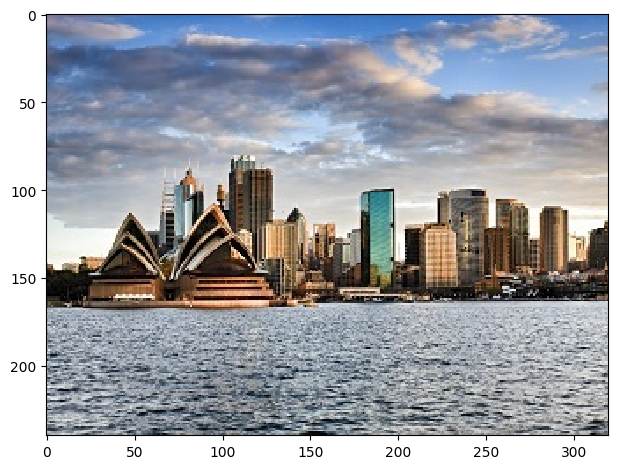

In [2]:

#Read the image
org_jpg = io.imread('./Technical Assessment - Data Science/sydney.jpg')
io.imshow(org_jpg)
io.show()

# lossless conversion
io.imsave('sydney.png', org_jpg)
org_png = io.imread('sydney.png')
org_filesize = os.path.getsize(f'sydney.png')

In [3]:
print(f'PSNR (orginal jpg vs saved png): {peak_signal_noise_ratio(org_jpg, org_png, data_range=None)} dB')
print(f'SSIM (orginal jpg vs saved png): {structural_similarity(org_jpg, org_png, channel_axis=2)}')


PSNR (orginal jpg vs saved png): inf dB
SSIM (orginal jpg vs saved png): 1.0


In [4]:
#Dimension of the original image
rows = org_png.shape[0]
cols = org_png.shape[1]

#Flatten the image
image = org_png.reshape(rows*cols, 3)

In [5]:
k_lst = [2, 3, 4, 8, 16, 32, 64, 128, 256]
time_lst = []
img_lst = []
metric_lst = []
size_lst = []


for n_cluster in k_lst:
    Kmedoids = KMedoids(n_clusters=n_cluster)
    i_time = time.process_time()
    Kmedoids.fit(image)
    f_time = time.process_time()
    compressed_im = Kmedoids.cluster_centers_[Kmedoids.labels_]
    compressed_im = np.clip(compressed_im.astype('uint8'), 0, 255)
    compressed_im = compressed_im.reshape(rows, cols, 3)
    io.imsave(f'sydney_compressed_kmedois_{n_cluster}.png', compressed_im)
    img_lst.append(compressed_im)
    psnr = peak_signal_noise_ratio(org_png, compressed_im, data_range=None)
    ssim = structural_similarity(org_png, compressed_im, channel_axis=2)
    metric_lst.append((psnr, ssim))
    time_lst.append(f_time-i_time)
    size_lst.append(os.path.getsize(f'sydney_compressed_kmedois_{n_cluster}.png'))
    
    


In [6]:
# Defining function for ploting images

def plot_images(image_lst, k_lst, metric_lst, time_lst, size_lst):
        """
        Plot three images in a row
        :param image_lst: image list
        :param k_lst: list of KMean clusters
        :param metric_lst: tuple of (PSNR,SSIM) for each image
        :param time_lst: list of process times
        :param size_lst: list of compressed file size
        :return: None
        """
        plt.figure(figsize=(24, 20))
        n = len(k_lst)//3

        for ii in range(n):
            
            titles = []
            for j in range(3):
                t1 = f'K:{k_lst[j+ii*n]}   time:{round(time_lst[j+ii*n]/600,2)} min'
                t2 = f'\nPNSR:{round(metric_lst[j+ii*n][0], 2)}  SSIM:{round(metric_lst[j+ii*n][1], 2)}'
                t3 = f'\nSize: {round(size_lst[j+ii*n]/1024,1)} kB Compress: {round((1-size_lst[j+ii*n]/org_filesize)*100,1)}%'
                titles.append(t1+t2+t3)
 
            for i, (img, title) in enumerate(zip(image_lst[ii*3: 3+ii*3], titles)):
                plt.subplot(n, 3, i + 1+ ii*3)
                plt.imshow(img)
                plt.title(title)
                plt.xticks([])
                plt.yticks([])

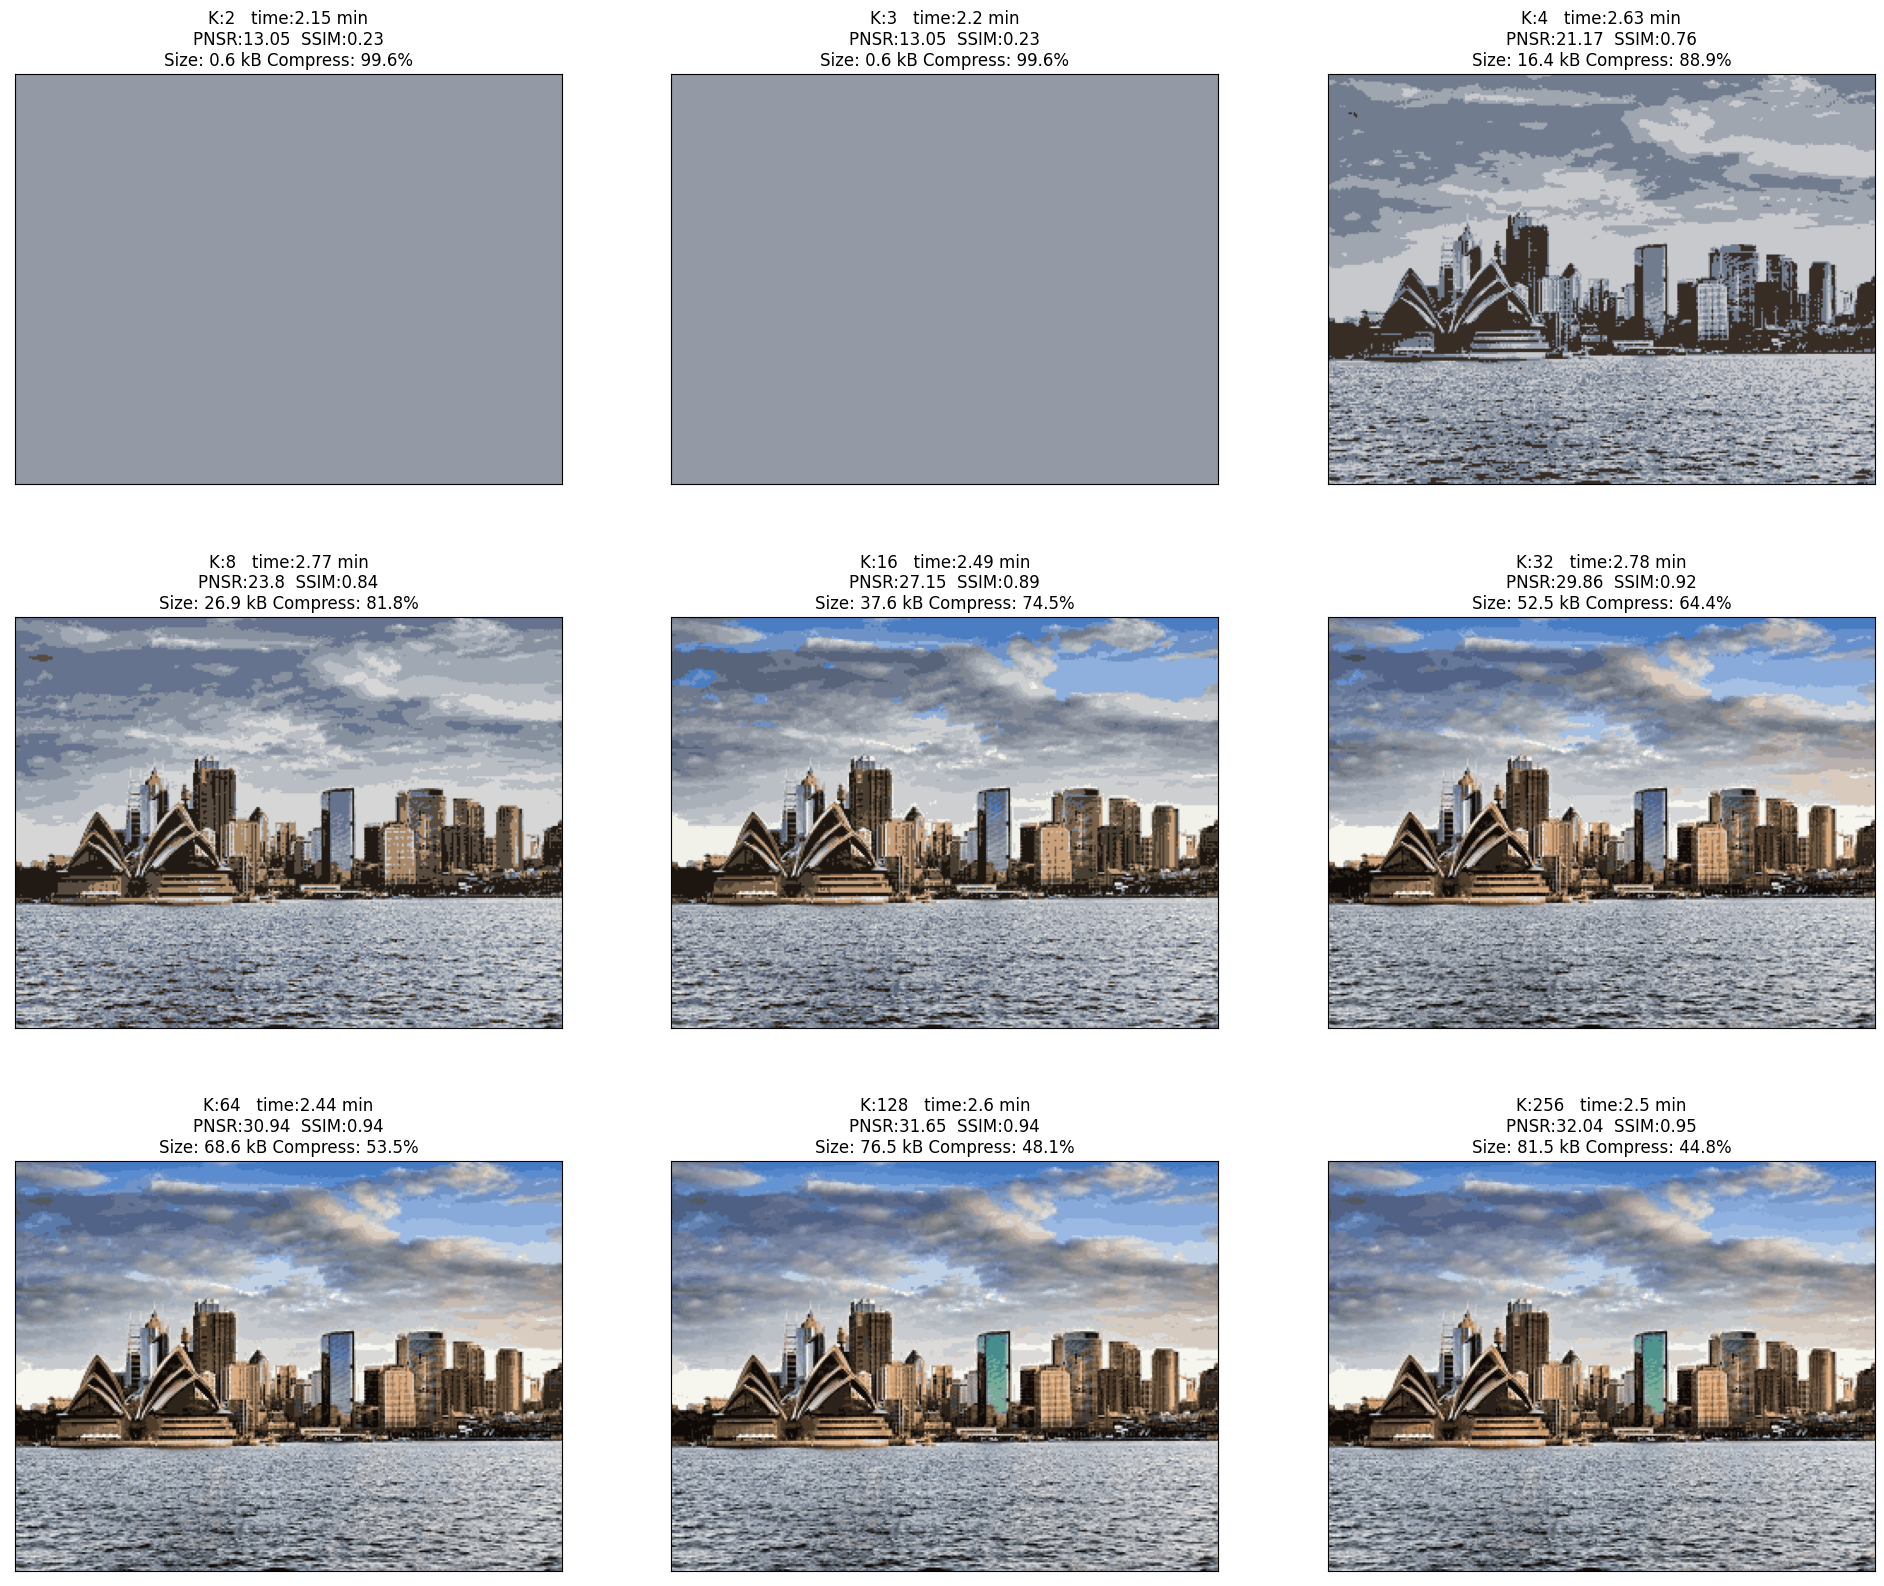

In [7]:
plot_images(img_lst, k_lst, metric_lst, time_lst, size_lst)

In [8]:
k_arr = np.array(k_lst)
time_arr = np.array(time_lst)
size_arr = np.array(size_lst)
psnr_arr = np.array(metric_lst)[:,0]
ssim_arr = np.array(metric_lst)[:,1]

dict_kmeans = {'KMedois': k_arr, 'PSNR (dB)': np.round(psnr_arr,2), 'SSIM': np.round(ssim_arr,2),'CPU_proc_time (s)': np.round(time_arr/10,2), 'Filesize (kB)': np.round(size_arr/1024,1)}

## Analytical results

In [9]:
df_output = pd.DataFrame(dict_kmeans)

df_output['Compression_level %'] = np.round((1-size_arr/org_filesize)*100,1)

df_output

,KMedois,PSNR (dB),SSIM,CPU_proc_time (s),Filesize (kB),Compression_level %
0,2,13.05,0.23,129.06,0.6,99.6
1,3,13.05,0.23,132.15,0.6,99.6
2,4,21.17,0.76,157.97,16.4,88.9
3,8,23.80,0.84,166.45,26.9,81.8
4,16,27.15,0.89,149.28,37.6,74.5
5,32,29.86,0.92,167.08,52.5,64.4
6,64,30.94,0.94,146.31,68.6,53.5
7,128,31.65,0.94,156.23,76.5,48.1
8,256,32.04,0.95,150.19,81.5,44.8
